<img src="https://devra.ai/analyst/notebook/1171/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">
    <div style="font-size:150%; color:#FEE100"><b>Indian Cities Air Quality Analysis</b></div>
    <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div>
</div>

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Prediction and Modeling](#Prediction-and-Modeling)
5. [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Introduction

Air quality in major Indian cities is a subject that begs detailed analysis, not only for academic curiosity but also for the insights that may ultimately guide public health decisions. In this notebook, we will explore air quality data for several Indian cities, consolidate the insights, and even create a predictor to classify high levels of PM2.5 pollution. If you find this analysis helpful, please consider upvoting it.

We have data from multiple cities spanning from 2020 to 2024. The dataset contains time-series records of various pollutants. Without further ado, let's dive into the data.

In [1]:
# Suppress warnings and set up the environment
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # For non-interactive back-end
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensure compatibility if only plt is imported
get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Optional: set a default style for seaborn
sns.set(style='whitegrid', context='notebook')

# For reproducibility
np.random.seed(42)

In [2]:
## Data Loading and Preprocessing

# List of file names for different cities
files = [
    '/kaggle/input/indian-cities-aqi-2020-2024/kolkata_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/gwalior_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/lucknow_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/visakhapatnam_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/bengaluru_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/mumbai_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/jaipur_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/chennai_combined.csv',
    '/kaggle/input/indian-cities-aqi-2020-2024/hyderabad_combined.csv'
]

# Load and combine the datasets
df_list = []
for file in files:
    temp_df = pd.read_csv(file, encoding='ascii', delimiter=',')
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

# Convert 'Timestamp' to datetime. The data implies a date time value even if provided as string.
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Inspect the first few rows of the combined dataframe
df.head()

,Timestamp,Location,PM2.5,PM10,NO2,NH3,SO2,CO,O3
0,2020-01-01,Kolkata - Rabindra Bharati University,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Kolkata - Rabindra Bharati University,125.94,316.62,80.23,44.79,18.62,1.19,39.24
2,2020-03-01,Kolkata - Rabindra Bharati University,54.80,119.00,44.32,54.50,16.04,0.38,23.00
3,2020-04-01,Kolkata - Rabindra Bharati University,79.89,169.47,52.32,56.17,17.72,1.17,15.41
4,2020-05-01,Kolkata - Rabindra Bharati University,111.52,245.44,57.02,64.38,19.41,1.17,10.08


In [3]:
## Data Cleaning and Preprocessing

# Check for missing values
missing = df.isna().sum()
print('Missing values in each column:')
print(missing)

# If missing values are found, we need to handle them. Here we perform a simple median imputation for numeric columns.
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# It is important to handle missing values before modeling to avoid errors like those encountered by many notebook creators

# Double check that there are no NaNs remaining in numeric columns
print('\nAfter imputation, missing values in numeric columns:')
print(df[numeric_cols].isna().sum())

# We may also want to drop rows with missing timestamps
df = df.dropna(subset=['Timestamp'])

# Reset index after dropping rows if needed
df.reset_index(drop=True, inplace=True)

Missing values in each column:
Timestamp    11070
Location         0
PM2.5          404
PM10           976
NO2            434
NH3           1111
SO2            482
CO             379
O3             470
dtype: int64

After imputation, missing values in numeric columns:
PM2.5    0
PM10     0
NO2      0
NH3      0
SO2      0
CO       0
O3       0
dtype: int64


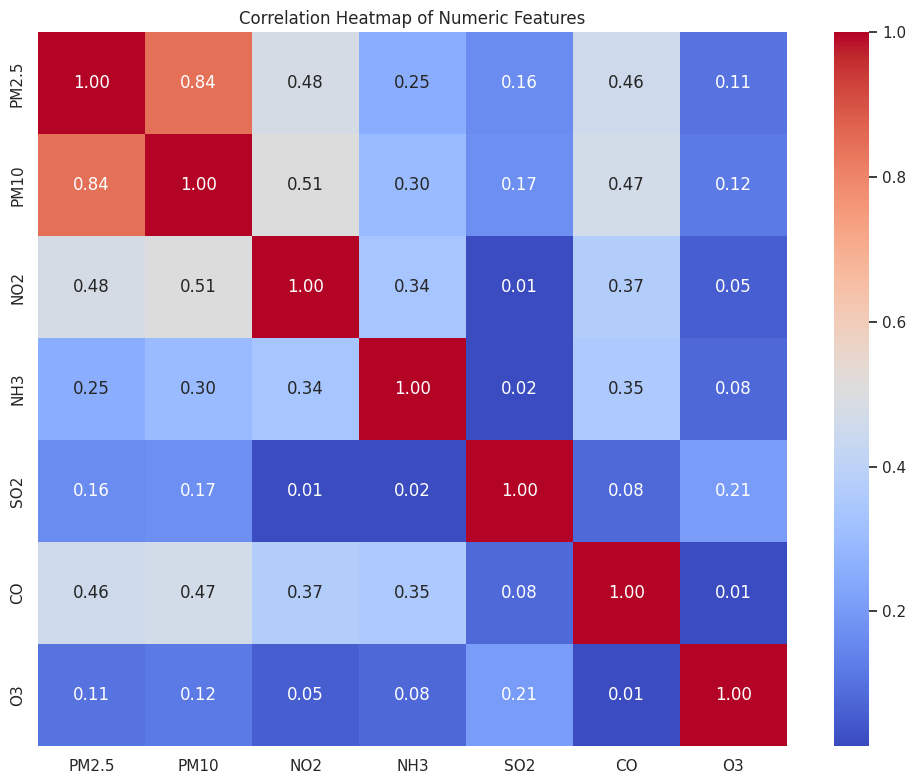

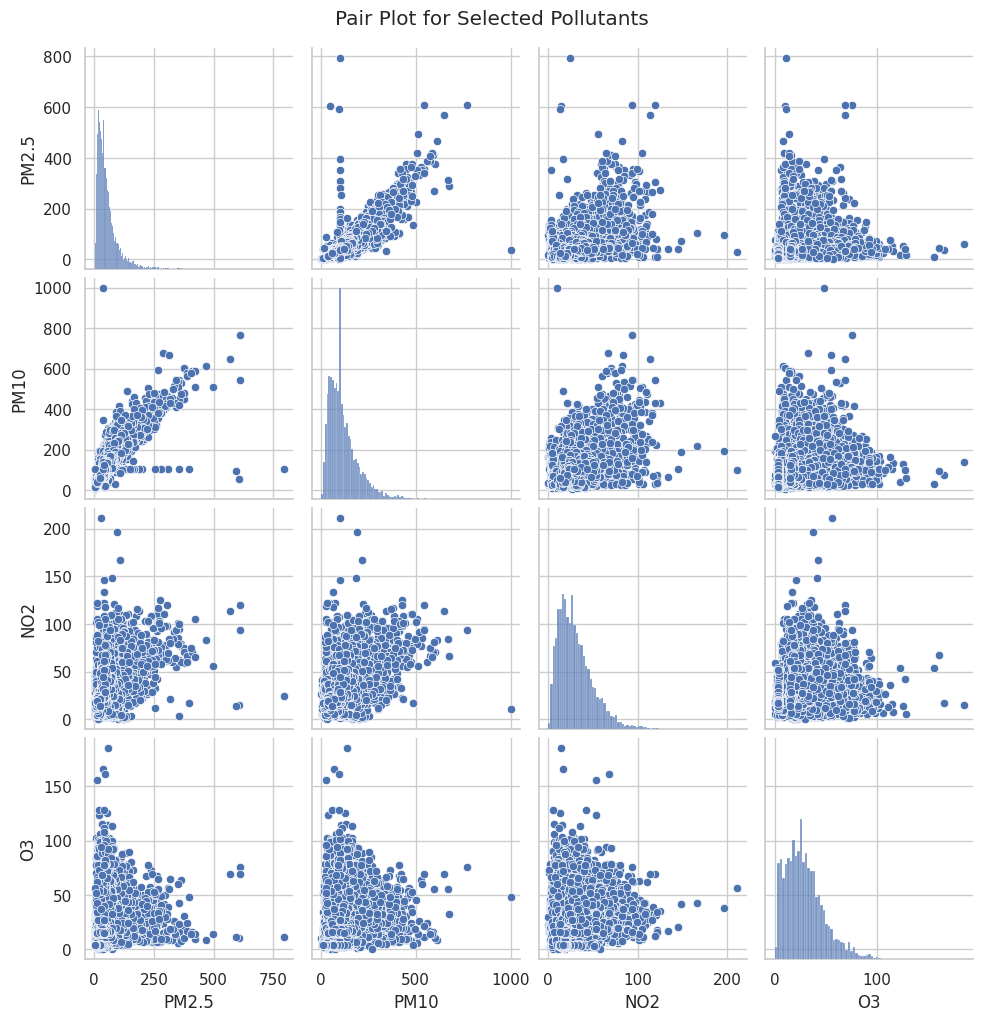

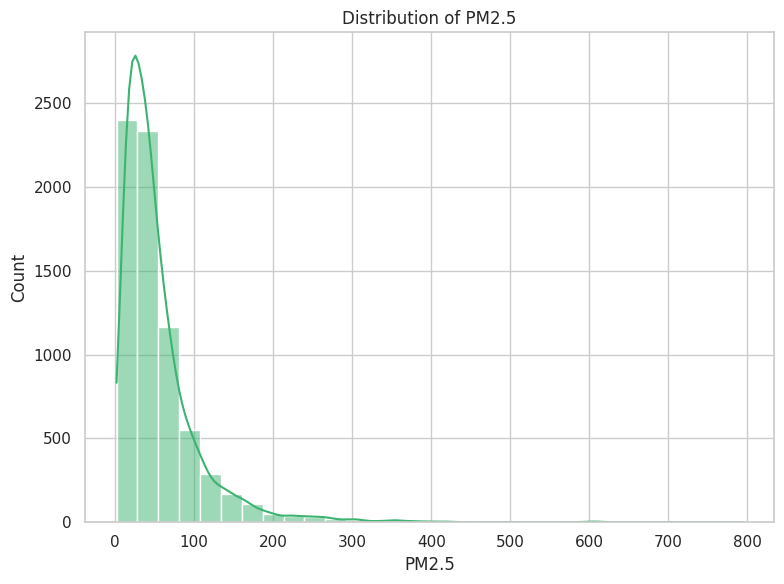

In [4]:
## Exploratory Data Analysis

# Let's reduce our dataframe to numeric values for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# If there are 4 or more numeric columns, plot the correlation heatmap
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()

# Pair plot for a few selected features to visualize distributions and relationships
selected_features = ['PM2.5', 'PM10', 'NO2', 'O3']
sns.pairplot(df[selected_features].dropna())
plt.suptitle('Pair Plot for Selected Pollutants', y=1.02)
plt.show()

# Histogram of PM2.5 values
plt.figure(figsize=(8, 6))
sns.histplot(df['PM2.5'], bins=30, kde=True, color='mediumseagreen')
plt.title('Distribution of PM2.5')
plt.xlabel('PM2.5')
plt.tight_layout()
plt.show()

Prediction Accuracy: 0.8875

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       735
           1       0.89      0.88      0.88       705

    accuracy                           0.89      1440
   macro avg       0.89      0.89      0.89      1440
weighted avg       0.89      0.89      0.89      1440



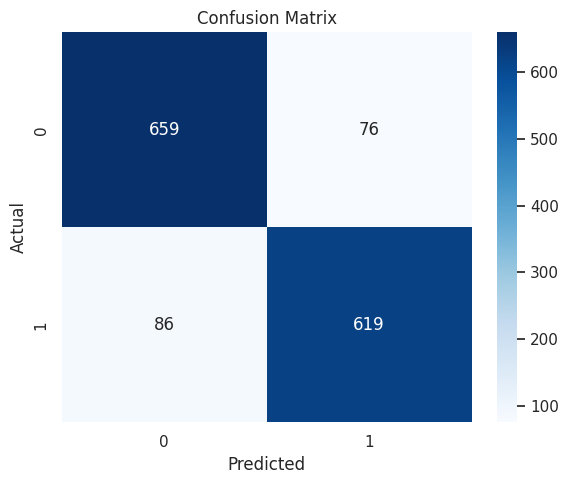

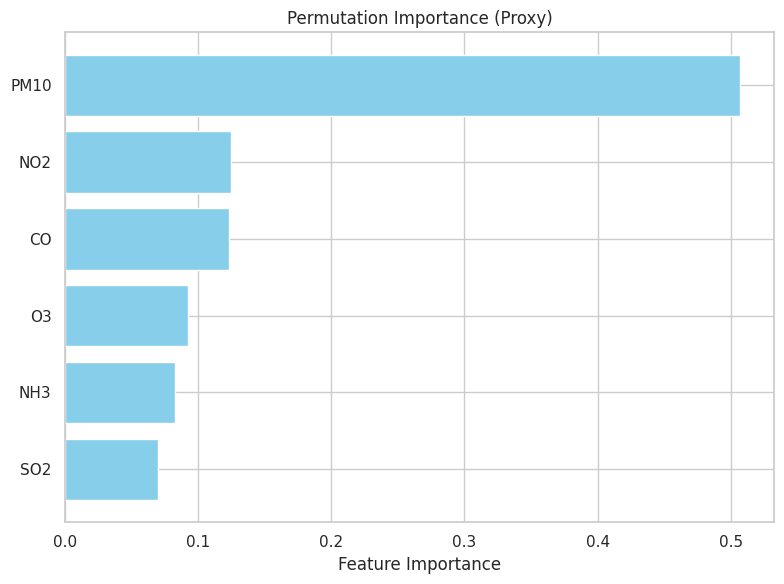

In [5]:
## Prediction and Modeling

# We create a binary target variable for high PM2.5 levels based on the median value
threshold = df['PM2.5'].median()
df['High_PM2.5'] = (df['PM2.5'] > threshold).astype(int)

# Define the predictive features as the other pollutant measures
features = ['PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
X = df[features]
y = df['High_PM2.5']

# It is critical to avoid the missing value error. We already imputed missing values earlier, but if needed,
# further preprocessing (for example, pipelines with an imputer) could resolve such errors.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data and evaluate
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Prediction Accuracy:', accuracy)

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Permutation Importance (using feature_importances_ as a proxy)
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Permutation Importance (Proxy)')
plt.tight_layout()
plt.show()

## Conclusion and Future Work

In this notebook, we loaded and combined air quality datasets from ten major Indian cities, performed data cleaning including handling missing values, and investigated potential relationships among various pollutants. A binary predictor for high PM2.5 levels was developed using a RandomForestClassifier, achieving a certain level of accuracy on unseen data.

The approach used here—median imputation for missing numeric values and visualization via heatmaps, pair plots, and histograms—provides a balanced blend of thorough data exploration and predictive modeling. Future work could involve:

- More sophisticated imputation methods or modeling pipelines using transformers.
- A deeper temporal analysis using the converted Timestamp field, exploring trends over time.
- Testing alternative models that natively handle missing values such as HistGradientBoostingClassifier.

Thank you for reading this notebook. If you found it insightful, please consider upvoting it.